**Connecting Colab to G-Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Moving to Path Folder & Installing  Dependencies**

In [1]:
%cd /content/drive/MyDrive/Resnet18

/content/drive/MyDrive/Resnet18


In [4]:
## Importing dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [2]:
!ls

APHU6500062_20240601072327.jpg	   dataset	    dataset_animals.zip  Res0.ipynb
Container_cls_Adam_60Ep_model.pth  dataset_animals  model.pth		 Res1.ipynb


**Data Transformations For Data Augmentation & Normalization**

In [5]:
## Data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=0, shear=20, scale=(0.8, 1.2)),  ## Shear range and zoom (in & out) range
        transforms.ToTensor(),                                           ## Transform to pixle values [0,1]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


**Dataset Path and Dataloader**

In [6]:
## Dataset path
data_dir = '/content/drive/MyDrive/Resnet18/dataset'

## Data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)         ## To print dataset size

class_names = image_datasets['train'].classes
print(class_names)            ## To print classes names

{'train': 353, 'val': 89}
['Clean', 'Garbage', 'Incomplete', 'Not Clean']


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Loading Pre-trained ResNet-18, Freezing All Layers Except layer4 & fc, Adding custom dense layers, Loss Function and Optimizer**

In [8]:
## Loading pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

## Freeze all layers except 'layer4' and 'fc'
for name, param in model.named_parameters():
    if "layer4" not in name and 'fc' not in name:
        param.requires_grad = False

## Parameters that gonna be trained
print("Parameters that gonna be trained:")
parameters_to_train = []
for name, param in model.named_parameters():
    if param.requires_grad:
        parameters_to_train.append(param)
        print("\t", name,param.requires_grad)
print("Total parameters to train:", len(parameters_to_train))

## Adding 4 FC layers
# Modify the final fully connected layer
num_ftrs = model.fc.in_features  # Number of features from the ResNet-18 backbone
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),    # First dense layer
    nn.ReLU(),                   # Activation for the first dense layer
    nn.Dropout(0.5),           # Dropout layer
    nn.Linear(256, 128),        # Second dense layer
    nn.ReLU(),                   # Activation for the second dense layer
    nn.Dropout(0.5),
    nn.Linear(128, 64),         # Third dense layer
    nn.ReLU(),                   # Activation for the third dense layer
    nn.Linear(64, len(class_names)),  # Fourth dense layer
    nn.Softmax(dim=1)            # Softmax activation for output probabilities
)



## Loss function & Optimizer
criterion = nn.CrossEntropyLoss()       ## Loss function
# optimizer = optim.SGD(model.parameters(), lr=5e-7, momentum=0.9)     ## Optimizer & LR = 5x10^-7
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

## Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Parameters that gonna be trained:
	 layer4.0.conv1.weight True
	 layer4.0.bn1.weight True
	 layer4.0.bn1.bias True
	 layer4.0.conv2.weight True
	 layer4.0.bn2.weight True
	 layer4.0.bn2.bias True
	 layer4.0.downsample.0.weight True
	 layer4.0.downsample.1.weight True
	 layer4.0.downsample.1.bias True
	 layer4.1.conv1.weight True
	 layer4.1.bn1.weight True
	 layer4.1.bn1.bias True
	 layer4.1.conv2.weight True
	 layer4.1.bn2.weight True
	 layer4.1.bn2.bias True
	 fc.weight True
	 fc.bias True
Total parameters to train: 17


**Model Summary**

In [13]:
!pip install torchinfo

from torchinfo import summary

## This model is our trained model
summary(model, input_size=(4, 3, 256, 256))  ## Batch size, No. of channels (RGB), Input size

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [4, 4]                    --
├─Conv2d: 1-1                            [4, 64, 128, 128]         (9,408)
├─BatchNorm2d: 1-2                       [4, 64, 128, 128]         (128)
├─ReLU: 1-3                              [4, 64, 128, 128]         --
├─MaxPool2d: 1-4                         [4, 64, 64, 64]           --
├─Sequential: 1-5                        [4, 64, 64, 64]           --
│    └─BasicBlock: 2-1                   [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [4, 64, 64, 64]           (36,864)
│    │    └─BatchNorm2d: 3-2             [4, 64, 64, 64]           (128)
│    │    └─ReLU: 3-3                    [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                  [4, 64, 64, 64]           (36,864)
│    │    └─BatchNorm2d: 3-5             [4, 64, 64, 64]           (128)
│    │    └─ReLU: 3-6                    [4, 64, 64, 64]   

**Training The Model**

train Loss: 1.3570 Acc: 0.4533
val Loss: 1.2585 Acc: 0.5281
train Loss: 1.2511 Acc: 0.5354
val Loss: 1.1771 Acc: 0.5506
train Loss: 1.1890 Acc: 0.5411
val Loss: 1.1588 Acc: 0.5506
train Loss: 1.1235 Acc: 0.6034
val Loss: 1.1225 Acc: 0.5506
train Loss: 1.1105 Acc: 0.6006
val Loss: 1.1025 Acc: 0.6517
train Loss: 1.0806 Acc: 0.6487
val Loss: 1.0969 Acc: 0.6517
train Loss: 1.0897 Acc: 0.6657
val Loss: 1.0591 Acc: 0.7191
train Loss: 1.0569 Acc: 0.6969
val Loss: 1.0446 Acc: 0.7191
train Loss: 1.0485 Acc: 0.7139
val Loss: 1.0433 Acc: 0.7079
train Loss: 1.0398 Acc: 0.7082
val Loss: 1.0542 Acc: 0.6854
train Loss: 1.0457 Acc: 0.7025
val Loss: 1.0234 Acc: 0.7191
train Loss: 1.0465 Acc: 0.6912
val Loss: 1.0247 Acc: 0.7191
train Loss: 1.0421 Acc: 0.7110
val Loss: 1.0339 Acc: 0.7079
train Loss: 1.0311 Acc: 0.7054
val Loss: 1.0031 Acc: 0.7303
train Loss: 1.0260 Acc: 0.7167
val Loss: 1.0542 Acc: 0.6854
train Loss: 1.0227 Acc: 0.7309
val Loss: 0.9970 Acc: 0.7416
train Loss: 1.0486 Acc: 0.6856
val Loss:

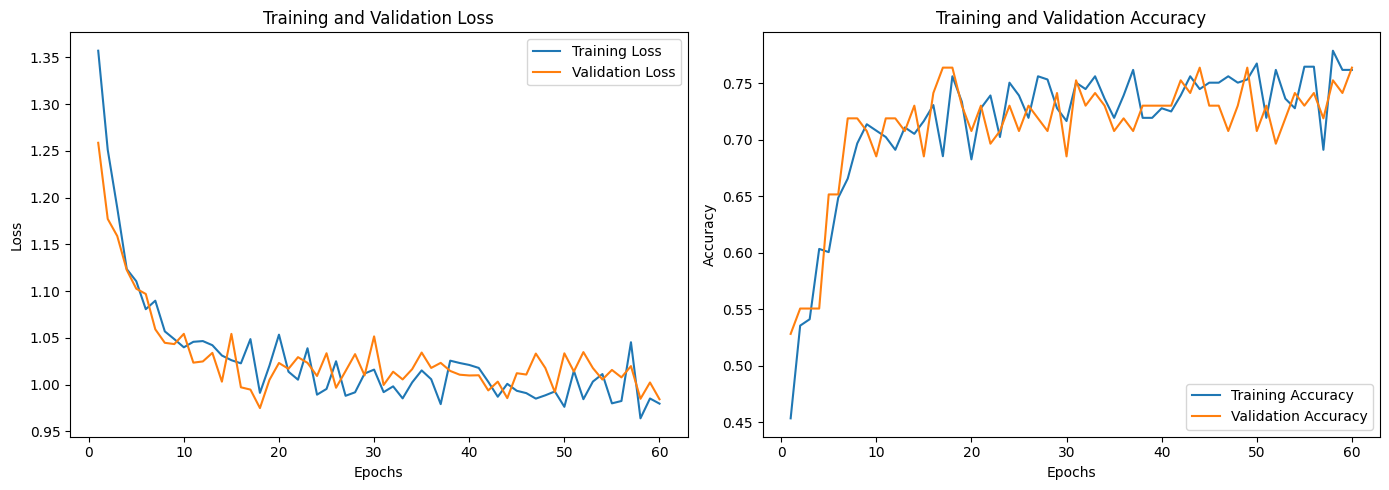

In [ ]:
## Training
import matplotlib.pyplot as plt

## Dictionaries to store train and val loss and accuracy
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

num_epochs = 60
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        ## Store the metrics in the history dictionary
        if phase == 'train':
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc.item())
        else:
            history['val_loss'].append(epoch_loss)
            history['val_acc'].append(epoch_acc.item())

print("Congrats Training complete!")

## Plot Loss and Accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))


## Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

## Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Training Accuracy')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



**Saving The Model**

In [ ]:
## Saving the model
# torch.save(model.state_dict(), 'Container_classifier_SGD_model.pth')
torch.save(model.state_dict(), 'Container_cls_Adam_60Ep_model.pth')

In [ ]:
torch.save(model, 'model.pth')

In [11]:
# import torch

# # Load the saved model
# model = torch.load('model.pth')

# # Move the model to the appropriate device
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

**Model Summary**

In [14]:
from torchinfo import summary

## This model is our trained model
summary(model, input_size=(4, 3, 256, 256))  ## Batch size, No. of channels (RGB), Input size

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [4, 4]                    --
├─Conv2d: 1-1                            [4, 64, 128, 128]         (9,408)
├─BatchNorm2d: 1-2                       [4, 64, 128, 128]         (128)
├─ReLU: 1-3                              [4, 64, 128, 128]         --
├─MaxPool2d: 1-4                         [4, 64, 64, 64]           --
├─Sequential: 1-5                        [4, 64, 64, 64]           --
│    └─BasicBlock: 2-1                   [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [4, 64, 64, 64]           (36,864)
│    │    └─BatchNorm2d: 3-2             [4, 64, 64, 64]           (128)
│    │    └─ReLU: 3-3                    [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                  [4, 64, 64, 64]           (36,864)
│    │    └─BatchNorm2d: 3-5             [4, 64, 64, 64]           (128)
│    │    └─ReLU: 3-6                    [4, 64, 64, 64]   

In [22]:
import torch
from torchvision import transforms
from PIL import Image

import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image

# Step 1: Define the model architecture
class ContainerClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(ContainerClassifier, self).__init__()
        self.backbone = models.resnet18(pretrained=False)
        self.backbone.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.backbone(x)

# Step 2: Create an instance of the model and load weights
model = ContainerClassifier(num_classes=4)
model.load_state_dict(torch.load('Container_cls_Adam_60Ep_model.pth'), strict=False)
model.eval()

# Step 3: Define preprocessing for input images
transform = Compose([
    Resize((256, 256)),  # Resize to match input size
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])

# Step 4: Load and preprocess an image
image_path = '/content/drive/MyDrive/Resnet18/Test/img0005.jpg'  # Path to your test image
image = Image.open(image_path).convert('RGB')  # Open and convert to RGB
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Step 5: Perform inference
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

print(f"Predicted Class: {predicted_class}")



# ['Clean', 'Garbage', 'Incomplete', 'Not Clean']
# Map class index to label (if applicable)
# class_labels = {0: "Clean", 1: "Garbage", 2: "Incomplete", 3: "Not Clean"}
# print(f"Predicted class: {class_labels[predicted_class.item()]}")


Predicted Class: 3


<ipython-input-22-c953d83df7cd>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Container_cls_Adam_60Ep_model.pth'), strict=False)


<!--  -->